In [1]:
import pyccl as ccl
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.special import jv as jnu
import sacc

/home/anze/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [151]:
def GetSliceCorr (Pofk,R,D,Dar):
    """ Gets correlation of discs of 
        radius R, thickness D for sample with bias and nbar.
        Cosmology object C at redshift z
    """
    ## first integrate in kperp
    kminperp=1e-8
    kmaxperp=10
    kminpar=1e-6
    kmaxpar=100
    kar=np.logspace(np.log(kminpar), np.log(kmaxpar), 1000)
    def KperpIntg (logkperp,kpar):
        kperp=np.exp(logkperp)
        Pk=Pofk(np.sqrt(kpar**2+kperp**2))
        airy=2*jnu(1,kperp*R)/(kperp*R)
        return airy**2*Pk*(2*np.pi*kperp)*kperp 
    
    def KparIntg (logkpar,dD):
        kpar=np.exp(logkpar)
        Pk=PkparI(kpar)
        sinc = np.sin(kpar*D/2)/(kpar*D/2)  ## -D/2 to + D/2
        return sinc**2*Pk*kpar*2*np.cos(dD*kpar)
    print ("Doing Kperp integration")
    Pkpar = np.array(
        [1/(2*np.pi)**3*quad(lambda lkperp:KperpIntg(lkperp,kpar),np.log(kminperp),np.log(kmaxperp),limit=500)[0] for kpar in kar])
    PkparI=interp1d(kar,Pkpar)
    print (Dar)
    print ("Doing Kpar integration")
    #Xi = np.array(
    #    [quad(lambda KparIntg,kminpar,kmaxpar,weight='cos',wvar=dD,limit=500)[0] for dD in Dar]
    #    )
    Xi = np.array(
        [quad(lambda lkpar:KparIntg(lkpar,dD),np.log(kminpar),np.log(kmaxpar),limit=500)[0] for dD in Dar]
        )
    return Dar,Xi

In [152]:
## Zero test:
## for P = const, we have Poisson sampling
## so we should just recover the 1/volume
R=200
D=30
nbar=1e-2
Dar,Xi=GetSliceCorr(lambda k:1/nbar, R,D,Dar=[0,D/2,9/10*D,D])
Nvol=(np.pi*R**2)*D*nbar
assert (Dar[0]==0)
print (1/Xi[0], Nvol, 1/Xi[0]/Nvol)

Doing Kperp integration
[0, 15.0, 27.0, 30]
Doing Kpar integration
37718.00485656713 37699.11184307752 1.0005011527477956


In [153]:
Xi/Xi[0] ## for poisson sampling, we expect the amount of correlation reflect the overlap of disks, so 1,0.5, 0.1, 0

array([1.00000000e+00, 5.00114428e-01, 1.00032780e-01, 1.23417109e-04])

In [154]:
## now let's plug in the linear matter power spectrum and see what happens
C=ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, h=0.7, n_s=0.96, sigma8=0.8)
PkInt=lambda k: ccl.linear_matter_power(C,k,1)+1/nbar

In [155]:
Dar,Xi=GetSliceCorr(PkInt, R=200,D=30,Dar=np.arange(5)*D)

Doing Kperp integration
[  0  30  60  90 120]
Doing Kpar integration


/home/anze/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


In [156]:
print(Xi)
print(Xi/Xi[0]) ## in slices of 30 Mpc the scross-corr is completelly negligible.

[0.00693182 0.00336369 0.00112202 0.00039857 0.00015464]
[1.         0.48525366 0.16186556 0.05749826 0.02230839]


In [115]:
# Try to make the same calculation in real space, just for sanity
def DiscReal(xi, R, D,dD,rmax=100):
    Nx=60
    Nd=60
    ## work with cartesian points
    X=np.linspace(-R,R,Nx)
    dx=X[1]-X[0]
    x1_=np.outer(X,np.ones(Nx))
    y1_=x1_.T
    x1_=x1_.flatten()
    y1_=y1_.flatten()
    d1_=np.sqrt(x1_**2+y1_**2)
    w=np.where(d1_<=R)
    x1_=x1_[w]
    y1_=y1_[w]
    ## offset the other grid
    X=np.linspace(-R-dx/2,R+dx/2,Nx+1)
    assert(X[1]-X[0]==dx)
    x2_=np.outer(X,np.ones(Nx))
    y2_=x2_.T
    x2_=x2_.flatten()
    y2_=y2_.flatten()
    d2_=np.sqrt(x2_**2+y2_**2)
    w=np.where(d2_<=R)
    x2_=x2_[w]
    y2_=y2_[w]
    zs=np.linspace(0,D,Nd)
    dz=zs[1]-zs[0]
    N1=len(x1_)
    N2=len(x2_)
    x1=np.outer(x1_,np.ones(N2)).flatten()
    y1=np.outer(y1_,np.ones(N2)).flatten()
    x2=np.outer(np.ones(N1),x2_).flatten()
    y2=np.outer(np.ones(N1),y2_).flatten()
    dr12sq=(x2-x1)**2+(y2-y1)**2
    s,sw=0,0
    dmin,dmax=1e30,0
    for z1 in zs:
        for z2 in zs+dD:
            dz=z2-z1
            dist=np.sqrt(dr12sq+dz**2)
            dmin=min(dist.min(),dmin)
            dmax=max(dist.max(),dmax)
            w=np.where(dist<rmax)
            s+=(xi(dist[w])).sum()
    print ("dmin,dmax=",dmin,dmax,N1,N2)
    sw=N1*N2
    return s/sw

In [157]:
rs=np.linspace(0,100,100)
xi=ccl.correlation_3d(C,1,rs)
xiin=interp1d(rs,xi)
DiscReal(xiin,R,D,0),DiscReal(xiin,R,D,D), DiscReal(xiin,R,D,2*D)

dmin,dmax= 4.793944279230788 400.17695741030843 2724 2692
dmin,dmax= 4.793944279230788 403.53636421290685 2724 2692
dmin,dmax= 30.38061720492804 409.0740730505562 2724 2692


(22.782404560282945, 10.983366198256778, 3.245475216419405)

array(0.0771438)

In [8]:
## Now imagine the universe to be sliced in 30 Mpc discs.
zar=np.linspace(0,3.0,1000)
Di=ccl.comoving_radial_distance(C,1/(1+zar))
DtoZ=interp1d(Di,zar)

In [9]:
## now create array of discks
dar, zar, ddistdz = [], [], []
cD,cZ=0,0
while cZ<2.5:
    dar.append(cD)
    cZ=float(DtoZ(cD))
    zar.append(cZ)
    ddistdz.append(3e3/(C['h']*ccl.h_over_h0(C,1/(1+cZ))))
    cD+=D
dar=np.array(dar)
zar=np.array(zar)
ddistdz=np.array(ddistdz)

In [15]:
sc=sacc.SACC.loadFromHDF('/home/anze/work/LSST/HSC_ceci/WIDE_GAMA09H_sirius_out/covana_noiana_msksirius_wssc_msksyst0_dpj0_dpb_bands1/power_spectra_wdpj.sacc')

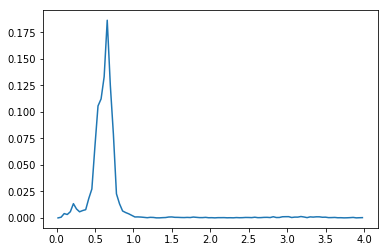

In [16]:
tr=sc.tracers[1]
plt.plot(tr.z,tr.Nz)

In [17]:
## we need to interpolate this onto the grid of 30MPc disks, taking jacobian into account
nzi=interp1d(tr.z,tr.Nz,fill_value=0,bounds_error=False)
Nzd=nzi(zar)/ddistdz
sig=np.sqrt(Xi[0])*0.95 ## note bias = 0.95/g**2 and we have here bias**2 * g**2 so it cancels, we ignore nbar here but small
mz=(Nzd*zar).sum()/Nzd.sum()
sigz=np.sqrt((Nzd*zar**2).sum()/Nzd.sum()-mz**2)
print('mean z=',mz,'sigma z=',sigz)

mean z= 0.6239734314386444 sigma z= 0.1885013943403559


(0.0, 1.0)

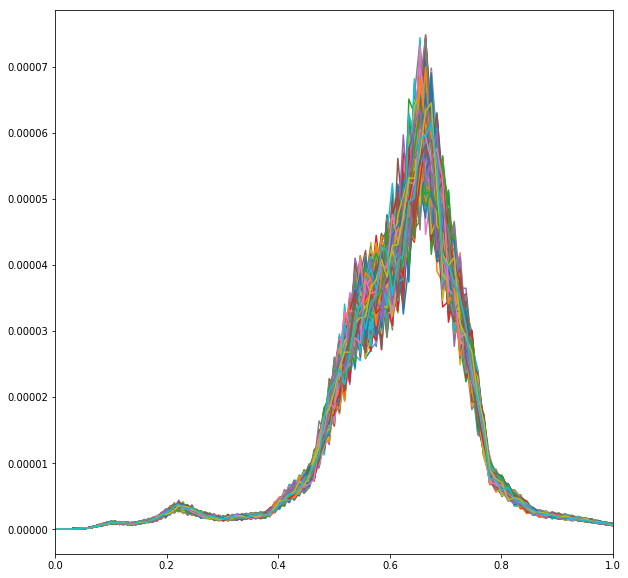

In [18]:
Ng=1000
plt.figure(figsize=(10,10))
mcmz,mcsig=[],[]
for i in range(Ng):
    Nzdc=Nzd*(1+np.random.normal(0,sig,len(Nzd)))
    plt.plot(zar,Nzdc)
    mzx=(Nzdc*zar).sum()/Nzdc.sum()
    sigzx=np.sqrt((Nzdc*zar**2).sum()/Nzdc.sum()-mzx**2)
    mcmz.append(mzx)
    mcsig.append(sigzx)
plt.xlim(0.0,1.0)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   3.,   2.,   4.,   8.,   7.,  14.,  27.,
         29.,  50.,  63.,  74.,  97.,  93., 108.,  96.,  80.,  61.,  55.,
         34.,  34.,  30.,  12.,   5.,   7.,   4.,   2.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([0.18  , 0.1803, 0.1806, 0.1809, 0.1812, 0.1815, 0.1818, 0.1821,
        0.1824, 0.1827, 0.183 , 0.1833, 0.1836, 0.1839, 0.1842, 0.1845,
        0.1848, 0.1851, 0.1854, 0.1857, 0.186 , 0.1863, 0.1866, 0.1869,
        0.1872, 0.1875, 0.1878, 0.1881, 0.1884, 0.1887, 0.189 , 0.1893,
        0.1896, 0.1899, 0.1902, 0.1905, 0.1908, 0.1911, 0.1914, 0.1917,
        0.192 , 0.1923, 0.1926, 0.1929, 0.1932, 0.1935, 0.1938, 0.1941,
        0.1944, 0.1947, 0.195 ]),
 <a list of 50 Patch objects>)

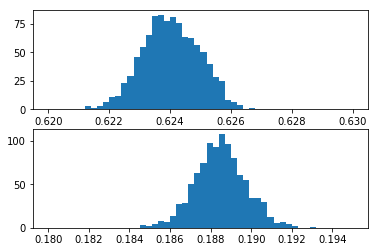

In [19]:
plt.subplot(2,1,1)
plt.hist(mcmz,bins=50,range=(0.62,0.63))
plt.subplot(2,1,2)
plt.hist(mcsig,bins=50,range=(0.180,0.195))